
# Algoritmo de triangulação

A triangulação do polígono é o primeiro ingrediente da nossa solução para o problema da galeria de arte. O objetivo desse notebook é explicar como fazer isso através do algoritmo de *ear decomposition* (decomposição por orelhas).  
Primeiro, lemos o polígono de um arquivo de entrada

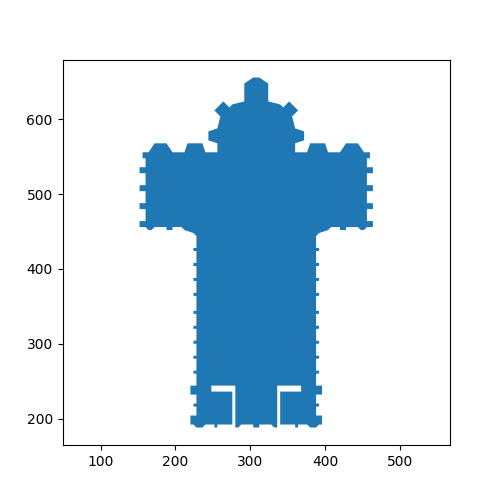

In [176]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random as rn
rn.seed()
# Selecione o polígono entre in0, in1, in2, ... in6
polygon = "in5"

# Leitura da entrada

with open("pols/" + polygon) as f:
    L = list(f.readline().split())

N = int(L[0])
L = L[1:]

points = []

for i in range(0, N):
    s, t = L[2*i], L[2*i+1]
    a, b = map(int, s.split('/'))
    c, d = map(int, t.split('/'))
    # Perturbação para evitar pontos colineares
    eps1, eps2 = rn.random()/1e4, rn.random()/1e4
    points.append((a/b + eps1, c/d+eps2))


# Plotar o polígono

def plt_pol():
    plt.figure(figsize=(5, 5))
    plt.axis('equal')
    xs = [x for (x, y) in points]
    ys = [y for (x, y) in points]
    plt.fill(xs, ys)
    plt.show()

plt_pol()

Precisamos de algumas primitivas geométricas

In [177]:
# Primitiva de sentido horário/anti-horário


def ccw(i, j, k, eps=1e-9):
    (ix, iy) = points[i]
    (jx, jy) = points[j]
    (kx, ky) = points[k]
    
    (vx, vy) = (jx - ix, jy - iy)
    (wx, wy) = (kx - jx, ky - jy)
    
    return vx*wy - vy*wx > eps


# Primitiva de estar dentro de um triângulo (l dentro de i, j, k)

def inside(i, j, k, l):
    return ccw(i, j, l) and ccw(j, k, l) and ccw(k, i, l)

Segue o algoritmo que decide se um ponto é uma orelha

In [178]:
# Sou ponta de orelha? Complexidade O(N)

def eartest(j):
    i, k = prev[j], prox[j]
    
    if not ccw(i, j, k):
        return False
    
    for l in range(0, N):
        if inside(i, j, k, l):
            return False

    return True

Segue o algoritmo de triangulação

In [179]:
# Triangulação. Complexidade: O(N^2)

def triangulate():  
    
    # Adjacência no polígono
    
    global prev, prox
    prev, prox = [], []
    for i in range(0, N):
        prev.append((i-1)%N)
        prox.append((i+1)%N)
    
    # Inicialmente, quem é orelha?
    
    ear = []
    
    for j in range(0, N):
        ear.append(eartest(j))
    
    triangulation = []
    remaining = N
    
    # Loop principal
    
    while remaining >= 3:
    
        # Encontrar uma orelha
        i = -1
        for j in range(0, N):
            if ear[j]:
                i = j
                break
        
        # Adicionar o triangulo encontrado
        triangulation.append((prev[i], i, prox[i]))
        ear[i] = False
        
        # Remover i do polígono
        prox[prev[i]] = prox[i]
        prev[prox[i]] = prev[i]
        remaining -= 1
        
        # Atualizar "status de orelha" dos vizinhos
        ear[prev[i]] = eartest(prev[i])
        ear[prox[i]] = eartest(prox[i])
        
    return triangulation

Agora, vamos plotar o resultado

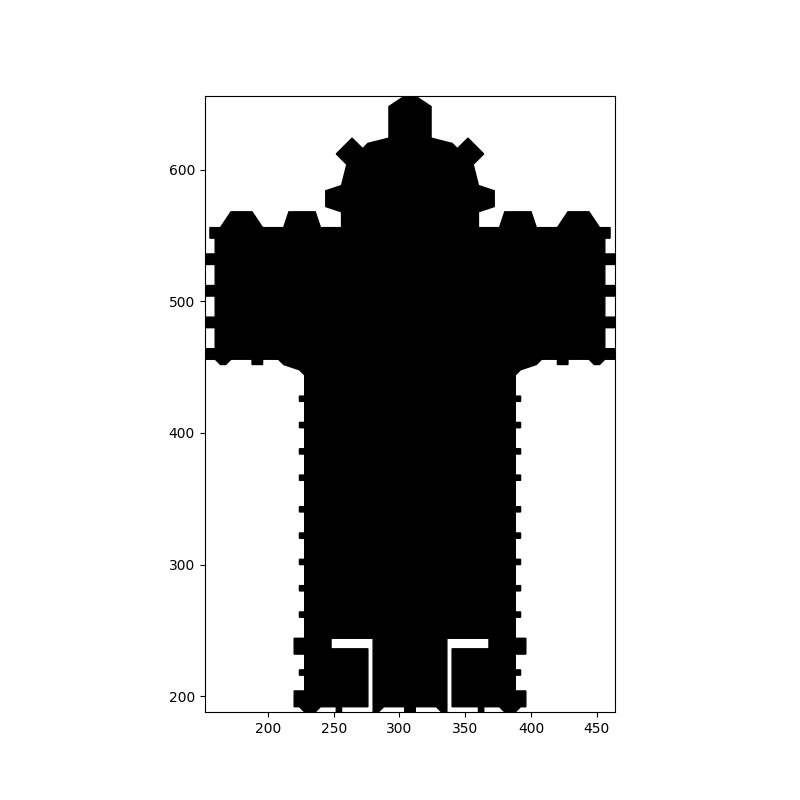

In [186]:
def plt_tring():
    plt.figure(figsize=(10, 10))
    plt.axis('equal')
    for t in triangulate():
        l = [points[i] for i in t]
        txs = [x for (x, y) in l]
        tys = [y for (x, y) in l]
        plt.fill(txs, tys, edgecolor='black', linewidth=0.1)
    plt.show()

def tring_anim(i):
    if(i==0):
        return arts
    t = tt[i-1]
    for p in range(1):
        l = [points[i] for i in t]
        txs = [x for (x, y) in l]
        tys = [y for (x, y) in l]
        pol = plt.fill(txs, tys, edgecolor='black', linewidth=0.1)[0]
        arts.append(pol)
    return arts

def anim():
    global tt, arts
    tt = triangulate()
    fig = plt.figure(figsize=(8, 8))
    xs, ys = [x for (x, y) in points], [y for (x, y) in points]
    ax = fig.add_subplot(autoscale_on=False, xlim=(min(xs), max(xs)), ylim=(min(ys), max(ys)))
    ax.set_aspect('equal')
    arts = [plt.fill(xs, ys, color='black')[0]]
    global ani
    ani = animation.FuncAnimation(fig, tring_anim, N-1, interval=1e4/N, blit=True, repeat=False)
    plt.show()

anim()

# Problema da Galeria de Arte

Para computar qual a menor quantidade de câmeras necessárias para vigiar toda a galeria de arte (representada pelo polígono) precisamos tentar cobrir a maior quantidade de triângulos com a menor quantidade de câmeras.

## Grafo Dual
Esse problema pode ser resolvido de forma mais simples se fizermos o grafo dual do nosso polígono triangulado. Vamos adotar cada triângulo como um vértice e dois vértices são adjascentes se seus triângulos compartilham uma lateral.

Segue o algoritmo que computa o grafo dual da triangulação

In [181]:
import networkx as nx # lib de grafos

triangulation = triangulate()

# Primeiro precisamos identificar quais triângulos possuem laterais em comum
def share_edge(tri1, tri2):
    # Cada triângulo possui 3 vértices, se dois triângulos compartilham
    # 2 vértices então eles possuem uma lateral em comum
    
    shared = set(tri1) & set(tri2)
    return len(shared) == 2

def compute_dual_graph(triangulation):
    graph = nx.Graph()
    num_triangles = len(triangulation)
    
    # Adicionando os vértices do grafo
    for i in range(num_triangles):
        graph.add_node(i)
    
    # Adicionando arestas se os triângulos compartilham uma lateral
    for i in range(num_triangles):
        for j in range(i + 1, num_triangles):
            if share_edge(triangulation[i], triangulation[j]):
                graph.add_edge(i, j)
                
    
    return graph

Agora vamos plotar o resultado

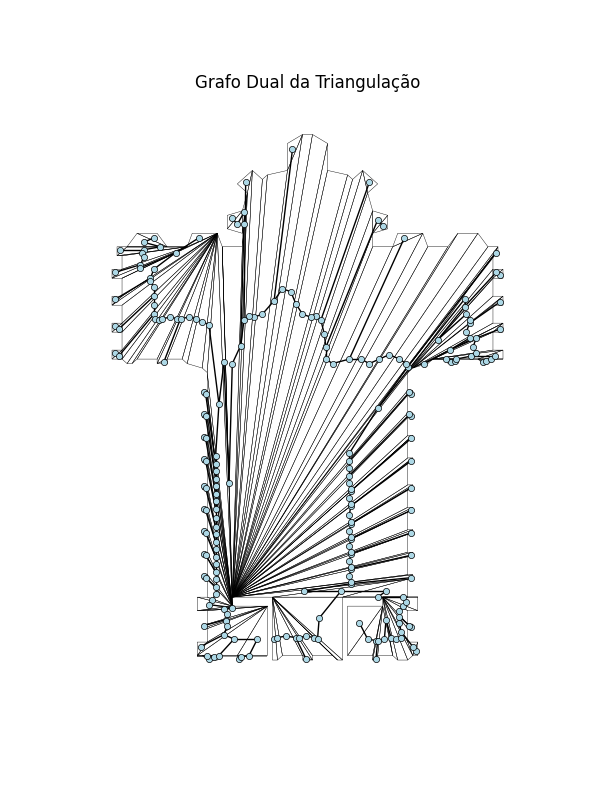

In [182]:
def plot_dual_graph(triangulation, dual_graph):
    pos = {}
    for i, tri in enumerate(triangulation):
        x = sum(points[v][0] for v in tri) / 3
        y = sum(points[v][1] for v in tri) / 3
        pos[i] = (x, y)

    plt.figure(figsize=(6, 8))
    
    # Plot para o grafo dual
    plt.title("Grafo Dual da Triangulação")
    for t in triangulation:
        t_points = [points[v] for v in t] + [points[t[0]]]
        xs, ys = zip(*t_points)
        plt.fill(xs, ys, edgecolor='black', linewidth=0.3, facecolor='none')
    nx.draw(dual_graph, pos, with_labels=False, node_size=20, node_color='lightblue', edgecolors='black', linewidths=0.5, edge_color='black')

    plt.show()
    
dual_graph = compute_dual_graph(triangulation)
plot_dual_graph(triangulation, dual_graph)

## Coloração de vértices
Agora que temos o grafo dual da triangulação, precisamos decidir onde e quantas câmeras devemos colocar na galeria.
O grafo dual nos dá a informação do relacionamento dos triângulos e vamos usar isso para colorir gulosamente os vértices da triangulação da seguinte forma:

- Primeiro escolhemos um triângulo e colorimos cada um de seus vértices com uma cor
- Depois vamos visitar um de seus vizinhos (obtemos isso do grafo dual) e tentar colori-lo
- Porém, dois triângulos só podem compartilhar 2 vértices, logo existe apenas uma cor possível para o vértice não colorido dos vizinhos de cada triângulo

Seque o algoritmo de 3-coloração dos triângulos

In [183]:
colors = {}  # dicionário -> triangulo: [a,b,c], onde a,b,c são as cores de seus vértices

color_map = {0: 'red', 1: 'blue', 2: 'green'}  # mapeamento das cores
reverse_color_map = {'red': 0, 'blue': 1, 'green': 2}  # mapeamento reverso

vertex_colors = {}  # coloração final da triangulação -> vertice: cor (string)

def dfs(current):
    triangle = triangulation[current]
    available = [0, 1, 2]
    
    print(f"Cores para o triangulo {current}: {available}")
    print(f"colorações dos triângulos: {colors}")
    
    for neighbor in dual_graph.neighbors(current):
        if neighbor in colors:
            n_colors = colors[neighbor]
            shared_vertices = set(triangle) & set(triangulation[neighbor])
            print(f"Vizinho {neighbor} colorido com {n_colors} e compartilha os vértices {shared_vertices}")
            
            for vertex in shared_vertices:
                if vertex in vertex_colors:
                    color_code = reverse_color_map[vertex_colors[vertex]]
                    print(f"Removendo cor {vertex_colors[vertex]}, com código: {color_code}")
                    available.remove(color_code)
                   
    print(f"Cores disponíveis depois de verificar os vizinhos: {available}")
    
    # Colorindo o triângulo atual com as cores disponíveis
    for color in available:
        for vertex in triangle:
            if vertex not in vertex_colors:
                vertex_colors[vertex] = color_map[color]
                print(f"Vertex {vertex} colored with {color_map[color]}")
                break
    
    colors[current] = [0,1,2]
        
    # Chamada recursiva da dfs nos triângulos vizinhos que ainda não foram coloridos
    for neighbor in dual_graph.neighbors(current):
        if neighbor not in colors:
            print(f"Recursao entrando no triangulo vizinho {neighbor}")
            dfs(neighbor)

# Chamada inicial da dfs na raiz do dual para colorir a triangulação
dfs(0)


Cores para o triangulo 0: [0, 1, 2]
colorações dos triângulos: {}
Cores disponíveis depois de verificar os vizinhos: [0, 1, 2]
Vertex 0 colored with red
Vertex 1 colored with blue
Vertex 2 colored with green
Recursao entrando no triangulo vizinho 1
Cores para o triangulo 1: [0, 1, 2]
colorações dos triângulos: {0: [0, 1, 2]}
Vizinho 0 colorido com [0, 1, 2] e compartilha os vértices {0, 2}
Removendo cor red, com código: 0
Removendo cor green, com código: 2
Cores disponíveis depois de verificar os vizinhos: [1]
Vertex 3 colored with blue
Recursao entrando no triangulo vizinho 2
Cores para o triangulo 2: [0, 1, 2]
colorações dos triângulos: {0: [0, 1, 2], 1: [0, 1, 2]}
Vizinho 1 colorido com [0, 1, 2] e compartilha os vértices {0, 3}
Removendo cor red, com código: 0
Removendo cor blue, com código: 1
Cores disponíveis depois de verificar os vizinhos: [2]
Vertex 231 colored with green
Recursao entrando no triangulo vizinho 3
Cores para o triangulo 3: [0, 1, 2]
colorações dos triângulos: {0

Agora vamos plotar o resultado da coloração

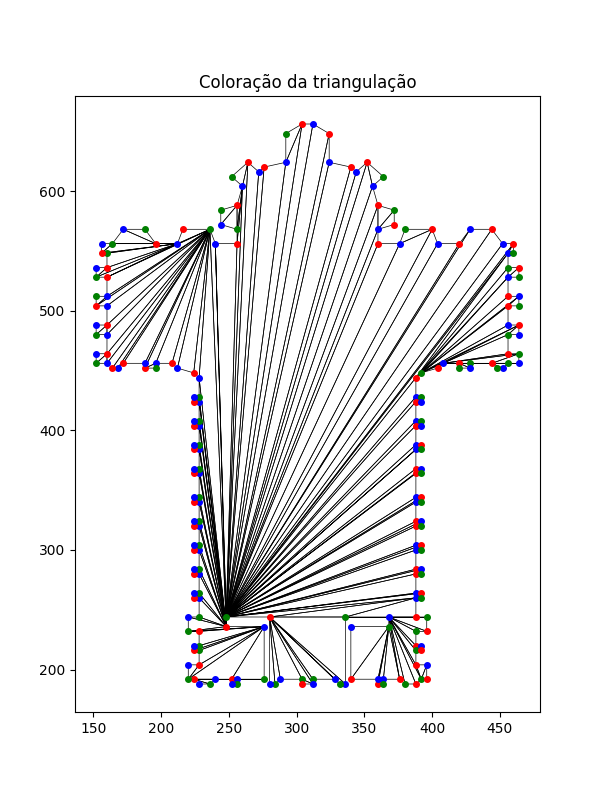

In [187]:
def plot_triangulation(triangulation, vertex_colors):
    plt.figure(figsize=(6, 8))
    for tri in triangulation:
        t_points = [points[v] for v in tri] + [points[tri[0]]]
        xs, ys = zip(*t_points)
        plt.fill(xs, ys, edgecolor='black', linewidth=0.5, facecolor='none')
    
    for vertex, color in vertex_colors.items():
        x, y = points[vertex]
        plt.plot(x, y, 'o', color=color, markersize=4)
    
    plt.title("Coloração da triangulação")
    plt.show()

plot_triangulation(triangulation, vertex_colors)

Agora para saber a menor quantidade de câmeras necessárias, precisamos olhar para a quantidade vértices da cor que coloriu menos vértices pois ela cobriu a maior quantidade de triângulos ao mesmo tempo, dado que todos os triângulos tem 1 vértice de cada cor.

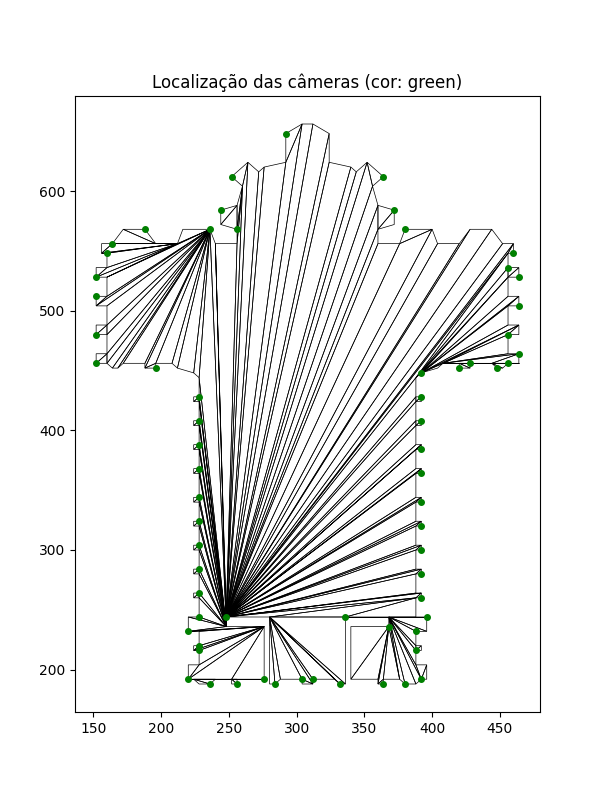

In [189]:
def plot_triangulation_min_color(triangulation, vertex_colors):
    plt.figure(figsize=(6, 8))
    
    # Calcular a contagem de vértices por cor
    color_counts = {'red': 0, 'blue': 0, 'green': 0}  # Inicialize com as cores disponíveis
    
    for color in vertex_colors.values():
        color_counts[color] += 1
    
    # Encontrar a cor com a menor contagem de vértices
    min_color = min(color_counts, key=color_counts.get)
    
    for tri in triangulation:
        t_points = [points[v] for v in tri] + [points[tri[0]]]
        xs, ys = zip(*t_points)
        plt.fill(xs, ys, edgecolor='black', linewidth=0.5, facecolor='none')
    
    # Plotar apenas os vértices com a menor cor
    for vertex, color in vertex_colors.items():
        if color == min_color:
            x, y = points[vertex]
            plt.plot(x, y, 'o', color=color, markersize=4)
    
    plt.title(f"Localização das câmeras (cor: {min_color})")
    plt.show()
    
plot_triangulation_min_color(triangulation, vertex_colors)